In [1]:
!pip install torchsummary
import torch
import torchvision
from torchsummary import summary


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader

mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_values, std=std_values)
        ])

CIFAR10 = torchvision.datasets.CIFAR10(root =  'Datasets', download=True, transform=transform, train=True)



Files already downloaded and verified


In [4]:
dataloader = DataLoader(CIFAR10, batch_size= 256,shuffle= True)

In [5]:
CIFAR10.__getitem__(0)[0].shape

torch.Size([3, 32, 32])

In [6]:
from torchvision.models import resnet34, ResNet34_Weights
import torch.nn as nn

resnet = resnet34(weights = ResNet34_Weights.DEFAULT).to(device)
resnet = nn.Sequential(*list(resnet.children())[:-1])

# summary(resnet, input_size=(3, 32, 32)) 

In [8]:
import torch.nn as nn
class model(nn.Module):
    def __init__(self, classifier, bit_length = 32):
        super(model, self).__init__()
        self.classifier = classifier

        # self.fc1 = nn.Sequential()
        # self.fc1.add_module('fc6_s1',nn.Linear(512, 1024)) #256*3*3
        # self.fc1.add_module('relu6_s1',nn.ReLU(inplace=True))
        # self.fc1.add_module('drop6_s1',nn.Dropout(p=0.5))

        # self.fc2 = nn.Sequential()
        # self.fc2.add_module('fc2',nn.Linear(1024, 512))
        # self.fc2.add_module('relu7',nn.ReLU(inplace=True))
        # self.fc2.add_module('drop7',nn.Dropout(p=0.5))

        # self.fc3 = nn.Sequential()
        # self.fc3.add_module('fc8',nn.Linear(512, hash_length))
        # self.fc3.add_module('tanh', nn.Tanh())
        self.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(512, 2048),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(2048, 2048),
                nn.ReLU(inplace=True),
                nn.Linear(2048, bit_length),
                # nn.Tanh()
            )
    def forward(self, x):
        x = self.classifier(x)
        x = torch.flatten(x, start_dim= 1, end_dim= 3)
        x = self.fc(x)
        # x = self.fc2(x)
        # x = self.fc3(x)
        return x
    

In [23]:
resnet_model = model(resnet, bit_length= 16)
resnet_model.to(device)

model(
  (classifier): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [18]:
image, labels = next(iter(dataloader))
image = image.to(device)
labels = labels.to(device)

output  = resnet_model(image)

In [19]:
one_hot_labels = torch.nn.functional.one_hot(labels)
one_hot_labels.dtype

torch.int64

In [13]:
import torch.nn.functional as F
class MSE_loss(nn.Module):
    def __init__(self):
        super(MSE_loss, self).__init__()   
    
    def forward(self, U,labels):
        L = F.one_hot(labels).to(torch.float64)
        S = torch.matmul(L, L.T)

        theta= 1/2 * torch.matmul(U, U.T)
        loss = torch.sum((S - theta) ** 2) 
        return loss

In [14]:
def dpsh_loss(b, labels):
    """
    DPSH loss function for pairwise labels in supervised hashing.
    
    Args:
    b (torch.Tensor): The batch of binary codes, shape [batch_size, code_length], each element should be -1 or 1.
    S (torch.Tensor): The matrix of pairwise labels, shape [batch_size, batch_size],
                      S[i, j] = 1 if i and j are similar, 0 otherwise.
    
    Returns:
    torch.Tensor: The computed loss value.
    """
    # Ensure b is a float tensor for matrix multiplication
    L = F.one_hot(labels).to(torch.float64)
    S = torch.matmul(L, L.T)
    b = b.float()
    
    # Compute the matrix of inner products
    sim_matrix = 0.5 * torch.matmul(b, b.t())
    
    # Calculate the DPSH loss
    positive_term = S * sim_matrix
    log_term = torch.log(1 + torch.exp(sim_matrix))
    loss = -torch.sum(positive_term - log_term)
    
    return loss


In [21]:
class log_loss(nn.Module):
    def __init__(self):
        super(log_loss, self).__init__()   
    
    def forward(self, U,labels):
        L = F.one_hot(labels).to(torch.float64)
        S = torch.matmul(L, L.T)

        
        theta= 1/2 * torch.matmul(U, U.T)

        J =  - (S * theta - torch.log(1 +   torch.exp(theta)))
        loss = 1/ 2 * torch.sum(J) 
        return loss

In [41]:
import torch.optim as optim
from tqdm import tqdm


for name, param in resnet_model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = False 

# parameters_to_optimize = [
#     resnet_model.fc1.parameters(),
#     resnet_model.fc2.parameters(),
#     resnet_model.fc3.parameters(),
# ]
# optimizer = optim.SGD(parameters_to_optimize, lr=0.001, momentum=0.9)
# optimizer = optim.SGD(resnet_model.fc.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)
eta =  0.1
epochs = 150

loss_fn = MSE_loss()

loss_list = []
mse_loss_list = []

for epoch in range(epochs):  # loop over the dataset multiple times
    loop = tqdm(dataloader)  
    total_loss = 0
    loss_ = 0
    for i, data in enumerate(loop):
        
        images, labels = data

        optimizer.zero_grad()
        
        images = images.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        U = resnet_model(images)
        
        reg = torch.sum((torch.sgn(U) - U)**2)
        
        loss = loss_fn(U, labels)
        loss_ += loss
        loss = loss + (eta * reg)

        total_loss += loss 

        loss.backward()
        optimizer.step()
        
        loop.set_postfix(epoch = epoch, loss=loss.item())
        
    total_loss = total_loss/ len(loop)
    loss_ = loss_/ len(loop)
    loss_list.append(total_loss.item())
    mse_loss_list.append(loss_.item())

    # if epoch % 5 == 0:
    print(f'Total loss:{total_loss.item()}, loss_ {loss_.item()}')
print('Finished Training')

100%|██████████| 196/196 [00:16<00:00, 11.71it/s, epoch=0, loss=139]    


Total loss:783.3153424094462, loss_ 588.8564052510563


100%|██████████| 196/196 [00:16<00:00, 11.83it/s, epoch=1, loss=114]   


Total loss:745.3349161233411, loss_ 551.4577068881299


100%|██████████| 196/196 [00:16<00:00, 11.79it/s, epoch=2, loss=178]    


Total loss:741.3005183978491, loss_ 547.5922704345859


100%|██████████| 196/196 [00:16<00:00, 11.71it/s, epoch=3, loss=110]    


Total loss:730.9256497992893, loss_ 537.2722128855072


100%|██████████| 196/196 [00:16<00:00, 11.71it/s, epoch=4, loss=99.4]   


Total loss:718.3413611730887, loss_ 524.8748655813217


100%|██████████| 196/196 [00:16<00:00, 11.73it/s, epoch=5, loss=121]    


Total loss:706.228596348352, loss_ 513.0797265808717


100%|██████████| 196/196 [00:16<00:00, 11.78it/s, epoch=6, loss=126]    


Total loss:699.5020028649259, loss_ 506.46960014515537


100%|██████████| 196/196 [00:16<00:00, 11.77it/s, epoch=7, loss=104]


Total loss:690.0904870495038, loss_ 497.0957604208307


100%|██████████| 196/196 [00:16<00:00, 11.77it/s, epoch=8, loss=114]   


Total loss:684.1721599459428, loss_ 491.33289758694696


100%|██████████| 196/196 [00:16<00:00, 11.81it/s, epoch=9, loss=99.3]   


Total loss:669.3676877247788, loss_ 476.72098297316035


100%|██████████| 196/196 [00:16<00:00, 11.77it/s, epoch=10, loss=114] 


Total loss:658.205571271484, loss_ 465.756910654512


100%|██████████| 196/196 [00:16<00:00, 11.75it/s, epoch=11, loss=178]


Total loss:652.495014884017, loss_ 460.09124305538506


100%|██████████| 196/196 [00:16<00:00, 11.78it/s, epoch=12, loss=122]


Total loss:659.9250838930637, loss_ 467.4373052294285


100%|██████████| 196/196 [00:16<00:00, 11.76it/s, epoch=13, loss=86.4]


Total loss:649.3074184665431, loss_ 457.0261312343193


100%|██████████| 196/196 [00:16<00:00, 11.75it/s, epoch=14, loss=102]


Total loss:657.1833353584896, loss_ 464.8222056172102


100%|██████████| 196/196 [00:16<00:00, 11.75it/s, epoch=15, loss=124]


Total loss:660.2507231907277, loss_ 467.7905394826928


100%|██████████| 196/196 [00:16<00:00, 11.72it/s, epoch=16, loss=82]    


Total loss:664.2251521819258, loss_ 471.7329680684429


100%|██████████| 196/196 [00:16<00:00, 11.66it/s, epoch=17, loss=101]


Total loss:645.9303548386736, loss_ 453.6958231441447


100%|██████████| 196/196 [00:18<00:00, 10.40it/s, epoch=18, loss=104]


Total loss:633.1921538734467, loss_ 441.11158583232617


100%|██████████| 196/196 [00:18<00:00, 10.79it/s, epoch=19, loss=84.2]


Total loss:633.9405367432397, loss_ 441.81197741660077


100%|██████████| 196/196 [00:17<00:00, 11.16it/s, epoch=20, loss=140]    


Total loss:628.9135111301333, loss_ 436.89975679149927


100%|██████████| 196/196 [00:17<00:00, 11.45it/s, epoch=21, loss=109]


Total loss:630.0147135593664, loss_ 438.01408791008987


100%|██████████| 196/196 [00:17<00:00, 11.46it/s, epoch=22, loss=117]   


Total loss:626.2178903676466, loss_ 434.26014773499463


100%|██████████| 196/196 [00:17<00:00, 11.18it/s, epoch=23, loss=108]


Total loss:623.2193258189423, loss_ 431.31441152740473


100%|██████████| 196/196 [00:17<00:00, 11.29it/s, epoch=24, loss=126]


Total loss:614.2879942779432, loss_ 422.4516378424401


100%|██████████| 196/196 [00:17<00:00, 11.27it/s, epoch=25, loss=103]


Total loss:616.6687735466433, loss_ 424.87818672475635


100%|██████████| 196/196 [00:17<00:00, 11.28it/s, epoch=26, loss=81] 


Total loss:623.0270584656554, loss_ 431.1035223401608


100%|██████████| 196/196 [00:17<00:00, 11.14it/s, epoch=27, loss=120]


Total loss:620.2630066626772, loss_ 428.38690477958727


100%|██████████| 196/196 [00:17<00:00, 10.99it/s, epoch=28, loss=139]


Total loss:612.6024500363663, loss_ 420.8412118214457


100%|██████████| 196/196 [00:18<00:00, 10.46it/s, epoch=29, loss=78.2]


Total loss:617.3495394166791, loss_ 425.4929472577975


100%|██████████| 196/196 [00:19<00:00, 10.12it/s, epoch=30, loss=99.8]


Total loss:628.2199462967304, loss_ 436.227415045796


100%|██████████| 196/196 [00:19<00:00, 10.28it/s, epoch=31, loss=105]


Total loss:622.0137195680123, loss_ 430.14415691293317


100%|██████████| 196/196 [00:18<00:00, 10.54it/s, epoch=32, loss=96.5]


Total loss:619.2907607774072, loss_ 427.4055706505602


100%|██████████| 196/196 [00:18<00:00, 10.55it/s, epoch=33, loss=107]


Total loss:603.0753623755885, loss_ 411.4592716594404


100%|██████████| 196/196 [00:18<00:00, 10.61it/s, epoch=34, loss=84.1]


Total loss:596.376897817766, loss_ 404.79853710450806


100%|██████████| 196/196 [00:18<00:00, 10.60it/s, epoch=35, loss=92.5]


Total loss:586.6747144704117, loss_ 395.2428071863955


100%|██████████| 196/196 [00:18<00:00, 10.65it/s, epoch=36, loss=82.7]


Total loss:593.5747410379131, loss_ 402.0865727496631


100%|██████████| 196/196 [00:18<00:00, 10.50it/s, epoch=37, loss=85.6]


Total loss:585.0989872067177, loss_ 393.7373389001632


100%|██████████| 196/196 [00:18<00:00, 10.57it/s, epoch=38, loss=84.6]


Total loss:589.4996801518307, loss_ 398.02501832474326


100%|██████████| 196/196 [00:18<00:00, 10.56it/s, epoch=39, loss=91.4]


Total loss:594.2083035674873, loss_ 402.6873883414268


100%|██████████| 196/196 [00:18<00:00, 10.56it/s, epoch=40, loss=102]


Total loss:593.523921696528, loss_ 401.9593135313321


100%|██████████| 196/196 [00:18<00:00, 10.52it/s, epoch=41, loss=83.5]


Total loss:601.174050733229, loss_ 409.60723636900985


100%|██████████| 196/196 [00:18<00:00, 10.54it/s, epoch=42, loss=97.2]


Total loss:598.9053671110714, loss_ 407.3673672767384


100%|██████████| 196/196 [00:18<00:00, 10.54it/s, epoch=43, loss=103]


Total loss:605.7966453833268, loss_ 414.0840469913853


100%|██████████| 196/196 [00:18<00:00, 10.44it/s, epoch=44, loss=76.9]


Total loss:596.4862155922618, loss_ 404.9275408967215


100%|██████████| 196/196 [00:18<00:00, 10.49it/s, epoch=45, loss=101]


Total loss:577.9665882337077, loss_ 386.67583220274935


100%|██████████| 196/196 [00:19<00:00, 10.25it/s, epoch=46, loss=76.2]


Total loss:570.4876641365794, loss_ 379.2515739435899


100%|██████████| 196/196 [00:18<00:00, 10.32it/s, epoch=47, loss=87.1]


Total loss:569.6662723397078, loss_ 378.5342117243238


100%|██████████| 196/196 [00:18<00:00, 10.44it/s, epoch=48, loss=127]


Total loss:581.0505975021543, loss_ 389.65374964100056


100%|██████████| 196/196 [00:18<00:00, 10.43it/s, epoch=49, loss=129]


Total loss:585.3747760776373, loss_ 393.91960462879354


100%|██████████| 196/196 [00:18<00:00, 10.44it/s, epoch=50, loss=105]


Total loss:579.3607146473346, loss_ 388.04943675177714


100%|██████████| 196/196 [00:18<00:00, 10.40it/s, epoch=51, loss=153]


Total loss:574.3029810983988, loss_ 383.0337836149468


100%|██████████| 196/196 [00:18<00:00, 10.39it/s, epoch=52, loss=93.4]


Total loss:581.206272086032, loss_ 389.8703870770452


100%|██████████| 196/196 [00:18<00:00, 10.32it/s, epoch=53, loss=92.9]


Total loss:574.7438781073456, loss_ 383.47269439277085


100%|██████████| 196/196 [00:19<00:00, 10.14it/s, epoch=54, loss=110]


Total loss:581.230358688885, loss_ 389.8483062283898


100%|██████████| 196/196 [00:19<00:00, 10.08it/s, epoch=55, loss=109]


Total loss:582.1120009173021, loss_ 390.75988623987274


100%|██████████| 196/196 [00:19<00:00, 10.20it/s, epoch=56, loss=108]


Total loss:565.8332785397255, loss_ 374.7547020041307


100%|██████████| 196/196 [00:18<00:00, 10.39it/s, epoch=57, loss=120]


Total loss:569.4811619134493, loss_ 378.2537261202539


100%|██████████| 196/196 [00:19<00:00, 10.22it/s, epoch=58, loss=78] 


Total loss:572.9487756694872, loss_ 381.75325203767136


100%|██████████| 196/196 [00:19<00:00, 10.31it/s, epoch=59, loss=80.2]


Total loss:557.9334357144973, loss_ 366.8915943827042


100%|██████████| 196/196 [00:19<00:00,  9.99it/s, epoch=60, loss=124]


Total loss:550.6880469237225, loss_ 359.72436365912637


100%|██████████| 196/196 [00:18<00:00, 10.40it/s, epoch=61, loss=135]


Total loss:564.2283801829177, loss_ 373.1190337542218


100%|██████████| 196/196 [00:19<00:00, 10.14it/s, epoch=62, loss=76.5]


Total loss:569.6352320304734, loss_ 378.4808936414468


100%|██████████| 196/196 [00:18<00:00, 10.35it/s, epoch=63, loss=95.6]


Total loss:564.5515719902148, loss_ 373.44235917323726


100%|██████████| 196/196 [00:18<00:00, 10.32it/s, epoch=64, loss=86.9]  


Total loss:561.8998282228791, loss_ 370.79645391684255


100%|██████████| 196/196 [00:19<00:00, 10.28it/s, epoch=65, loss=72.4]


Total loss:561.658920310419, loss_ 370.61455594563927


100%|██████████| 196/196 [00:19<00:00, 10.21it/s, epoch=66, loss=154]


Total loss:568.3293178800689, loss_ 377.1403222267999


100%|██████████| 196/196 [00:18<00:00, 10.33it/s, epoch=67, loss=76.5]


Total loss:568.7875654188786, loss_ 377.63026639659324


100%|██████████| 196/196 [00:18<00:00, 10.32it/s, epoch=68, loss=84.8]


Total loss:558.8395292622192, loss_ 367.78029579138035


100%|██████████| 196/196 [00:19<00:00, 10.28it/s, epoch=69, loss=84.7]


Total loss:546.884194346945, loss_ 356.0273154434974


100%|██████████| 196/196 [00:19<00:00, 10.31it/s, epoch=70, loss=99.7]


Total loss:537.212202578778, loss_ 346.47007247440126


100%|██████████| 196/196 [00:19<00:00, 10.22it/s, epoch=71, loss=106]


Total loss:550.6121883401672, loss_ 359.6720368336262


100%|██████████| 196/196 [00:19<00:00, 10.26it/s, epoch=72, loss=94.6]


Total loss:550.4653804725278, loss_ 359.52670001835133


100%|██████████| 196/196 [00:19<00:00, 10.26it/s, epoch=73, loss=130]


Total loss:548.8942833187947, loss_ 357.97476301853277


100%|██████████| 196/196 [00:19<00:00, 10.24it/s, epoch=74, loss=77.5]


Total loss:549.2004696512637, loss_ 358.2773397521024


100%|██████████| 196/196 [00:19<00:00, 10.26it/s, epoch=75, loss=120]


Total loss:554.0004038710855, loss_ 363.0053314284276


100%|██████████| 196/196 [00:19<00:00, 10.26it/s, epoch=76, loss=83.8]


Total loss:539.7765869979859, loss_ 349.0085184508349


100%|██████████| 196/196 [00:19<00:00, 10.27it/s, epoch=77, loss=119]


Total loss:544.8441349218175, loss_ 353.91046598724813


100%|██████████| 196/196 [00:19<00:00, 10.23it/s, epoch=78, loss=91.9]


Total loss:552.4601780453927, loss_ 361.55551186487907


100%|██████████| 196/196 [00:19<00:00, 10.01it/s, epoch=79, loss=106]


Total loss:558.8475637844048, loss_ 367.7668854868559


100%|██████████| 196/196 [00:19<00:00, 10.14it/s, epoch=80, loss=94.6]


Total loss:552.2935796681802, loss_ 361.38875202476646


100%|██████████| 196/196 [00:19<00:00, 10.13it/s, epoch=81, loss=104]


Total loss:545.0716173577971, loss_ 354.1612913732314


100%|██████████| 196/196 [00:19<00:00, 10.06it/s, epoch=82, loss=79.3]


Total loss:537.8447793901161, loss_ 347.06957430342766


100%|██████████| 196/196 [00:19<00:00, 10.27it/s, epoch=83, loss=96.5]


Total loss:540.0434576305207, loss_ 349.24231003334415


100%|██████████| 196/196 [00:19<00:00, 10.14it/s, epoch=84, loss=78.5]


Total loss:534.0786721258851, loss_ 343.3772762152715


100%|██████████| 196/196 [00:19<00:00, 10.23it/s, epoch=85, loss=122]


Total loss:542.7760414618288, loss_ 351.94317500721746


100%|██████████| 196/196 [00:19<00:00, 10.24it/s, epoch=86, loss=122]


Total loss:530.5513050607736, loss_ 339.87528426335564


100%|██████████| 196/196 [00:19<00:00, 10.22it/s, epoch=87, loss=75] 


Total loss:536.9098897094976, loss_ 346.11605368028916


100%|██████████| 196/196 [00:19<00:00, 10.15it/s, epoch=88, loss=94.6]


Total loss:543.9002822874188, loss_ 353.0480595333877


100%|██████████| 196/196 [00:19<00:00, 10.08it/s, epoch=89, loss=84] 


Total loss:546.3597155949254, loss_ 355.46844569699743


100%|██████████| 196/196 [00:19<00:00,  9.80it/s, epoch=90, loss=84.8]


Total loss:555.6837898809434, loss_ 364.706096634608


100%|██████████| 196/196 [00:19<00:00,  9.82it/s, epoch=91, loss=90] 


Total loss:533.7874788249203, loss_ 343.0720729714932


100%|██████████| 196/196 [00:19<00:00, 10.10it/s, epoch=92, loss=114]


Total loss:527.2092226630382, loss_ 336.5752697047951


100%|██████████| 196/196 [00:19<00:00, 10.14it/s, epoch=93, loss=77.5]


Total loss:519.8861393604651, loss_ 329.40690873274303


100%|██████████| 196/196 [00:19<00:00, 10.19it/s, epoch=94, loss=80.4]


Total loss:522.0724704133088, loss_ 331.48941082991684


100%|██████████| 196/196 [00:19<00:00, 10.09it/s, epoch=95, loss=89.1]


Total loss:528.9485806577164, loss_ 338.3161503670268


100%|██████████| 196/196 [00:19<00:00,  9.95it/s, epoch=96, loss=92] 


Total loss:539.092563783249, loss_ 348.3544452028396


100%|██████████| 196/196 [00:19<00:00, 10.17it/s, epoch=97, loss=100]


Total loss:543.6916270315269, loss_ 352.8425244857686


100%|██████████| 196/196 [00:19<00:00, 10.15it/s, epoch=98, loss=98.2]


Total loss:542.1302009907821, loss_ 351.35939899894964


100%|██████████| 196/196 [00:19<00:00, 10.19it/s, epoch=99, loss=118]


Total loss:547.8219905515567, loss_ 356.9036839478332


100%|██████████| 196/196 [00:19<00:00, 10.12it/s, epoch=100, loss=87.9]


Total loss:537.9399150310994, loss_ 347.1280810461019


100%|██████████| 196/196 [00:19<00:00, 10.18it/s, epoch=101, loss=74] 


Total loss:529.6800631806723, loss_ 338.98686063644044


100%|██████████| 196/196 [00:19<00:00, 10.19it/s, epoch=102, loss=99.7]


Total loss:521.1299750630828, loss_ 330.53706071533725


100%|██████████| 196/196 [00:19<00:00, 10.20it/s, epoch=103, loss=105]


Total loss:520.2084851599249, loss_ 329.6932296795286


100%|██████████| 196/196 [00:19<00:00, 10.18it/s, epoch=104, loss=99.7]


Total loss:515.7087144442144, loss_ 325.26791895449423


100%|██████████| 196/196 [00:19<00:00, 10.18it/s, epoch=105, loss=85.2]


Total loss:525.456390891758, loss_ 334.849520610305


100%|██████████| 196/196 [00:19<00:00, 10.21it/s, epoch=106, loss=116]


Total loss:530.9918458567731, loss_ 340.3157756434556


100%|██████████| 196/196 [00:19<00:00, 10.12it/s, epoch=107, loss=96] 


Total loss:529.4980482910222, loss_ 338.8427906183423


100%|██████████| 196/196 [00:19<00:00, 10.18it/s, epoch=108, loss=114]


Total loss:530.1496406546172, loss_ 339.5694966093128


100%|██████████| 196/196 [00:19<00:00, 10.18it/s, epoch=109, loss=95.2]


Total loss:523.2875531569961, loss_ 332.7733876484921


100%|██████████| 196/196 [00:19<00:00, 10.22it/s, epoch=110, loss=98.7]


Total loss:519.9405586314872, loss_ 329.44546061478695


100%|██████████| 196/196 [00:19<00:00, 10.22it/s, epoch=111, loss=102]


Total loss:511.13189407243226, loss_ 320.74673105718335


100%|██████████| 196/196 [00:19<00:00,  9.83it/s, epoch=112, loss=78.9]


Total loss:518.0027451982793, loss_ 327.5228445267683


100%|██████████| 196/196 [00:19<00:00, 10.05it/s, epoch=113, loss=76] 


Total loss:522.8211238709819, loss_ 332.2809367943351


100%|██████████| 196/196 [00:19<00:00, 10.12it/s, epoch=114, loss=70.6]


Total loss:520.8767459293407, loss_ 330.3383346526596


100%|██████████| 196/196 [00:19<00:00, 10.15it/s, epoch=115, loss=88.6]


Total loss:514.0290492326445, loss_ 323.58242652037325


100%|██████████| 196/196 [00:19<00:00, 10.19it/s, epoch=116, loss=90.2]


Total loss:507.88964934277215, loss_ 317.56711118100725


100%|██████████| 196/196 [00:19<00:00, 10.15it/s, epoch=117, loss=92] 


Total loss:514.3032592246329, loss_ 323.8817857020574


100%|██████████| 196/196 [00:19<00:00, 10.18it/s, epoch=118, loss=84.9]


Total loss:518.4250338531207, loss_ 327.97054733706346


100%|██████████| 196/196 [00:19<00:00, 10.15it/s, epoch=119, loss=94.4]


Total loss:513.666780162966, loss_ 323.25575089224924


100%|██████████| 196/196 [00:19<00:00, 10.17it/s, epoch=120, loss=104]


Total loss:518.1943065002531, loss_ 327.6773558540281


100%|██████████| 196/196 [00:19<00:00, 10.23it/s, epoch=121, loss=83.8]


Total loss:515.0923886195646, loss_ 324.6705998005826


100%|██████████| 196/196 [00:19<00:00, 10.19it/s, epoch=122, loss=88.2]


Total loss:516.945261876374, loss_ 326.47872671685445


100%|██████████| 196/196 [00:19<00:00, 10.23it/s, epoch=123, loss=125]


Total loss:513.9439049910659, loss_ 323.4649162462913


100%|██████████| 196/196 [00:19<00:00, 10.15it/s, epoch=124, loss=87.6]


Total loss:515.1038376955131, loss_ 324.68101260234147


100%|██████████| 196/196 [00:19<00:00, 10.13it/s, epoch=125, loss=86.4]


Total loss:517.1878995797388, loss_ 326.6804110370651


100%|██████████| 196/196 [00:19<00:00, 10.12it/s, epoch=126, loss=102]


Total loss:516.6465535100573, loss_ 326.16805382504214


100%|██████████| 196/196 [00:19<00:00, 10.16it/s, epoch=127, loss=82.7]


Total loss:513.5710895128738, loss_ 323.15554439964075


100%|██████████| 196/196 [00:19<00:00, 10.03it/s, epoch=128, loss=98.9]


Total loss:510.74430461799994, loss_ 320.4160081707134


100%|██████████| 196/196 [00:19<00:00, 10.15it/s, epoch=129, loss=120]


Total loss:510.0505144879103, loss_ 319.69315553595214


100%|██████████| 196/196 [00:19<00:00, 10.16it/s, epoch=130, loss=149]


Total loss:504.4344444241025, loss_ 314.18671325422673


100%|██████████| 196/196 [00:19<00:00, 10.08it/s, epoch=131, loss=111]


Total loss:494.6441128493315, loss_ 304.4737789675642


100%|██████████| 196/196 [00:19<00:00, 10.23it/s, epoch=132, loss=103]


Total loss:506.9092964986825, loss_ 316.58915079437395


100%|██████████| 196/196 [00:19<00:00, 10.14it/s, epoch=133, loss=91.8]


Total loss:511.4288735315464, loss_ 321.06088617127307


100%|██████████| 196/196 [00:19<00:00, 10.14it/s, epoch=134, loss=129]


Total loss:512.8769885046198, loss_ 322.4552354386934


100%|██████████| 196/196 [00:19<00:00, 10.10it/s, epoch=135, loss=82.2]


Total loss:522.4003110912342, loss_ 331.8953230242303


100%|██████████| 196/196 [00:19<00:00, 10.04it/s, epoch=136, loss=72] 


Total loss:508.2663148856315, loss_ 317.8895255006725


100%|██████████| 196/196 [00:19<00:00, 10.14it/s, epoch=137, loss=87.7]


Total loss:502.61373329909225, loss_ 312.3027758964934


100%|██████████| 196/196 [00:19<00:00, 10.08it/s, epoch=138, loss=89.8]


Total loss:500.75440961627436, loss_ 310.53594643869036


100%|██████████| 196/196 [00:19<00:00, 10.14it/s, epoch=139, loss=85.7]


Total loss:496.8958756193396, loss_ 306.68968113096986


100%|██████████| 196/196 [00:19<00:00, 10.16it/s, epoch=140, loss=109]


Total loss:500.4267040777628, loss_ 310.1829439493525


100%|██████████| 196/196 [00:19<00:00, 10.11it/s, epoch=141, loss=105]


Total loss:504.2782479255103, loss_ 314.0444239157123


100%|██████████| 196/196 [00:19<00:00, 10.13it/s, epoch=142, loss=92] 


Total loss:504.24341783203255, loss_ 313.9628488138829


100%|██████████| 196/196 [00:19<00:00, 10.09it/s, epoch=143, loss=103]


Total loss:501.93325926950826, loss_ 311.6805168135781


100%|██████████| 196/196 [00:19<00:00, 10.01it/s, epoch=144, loss=99.1]


Total loss:498.7192801068136, loss_ 308.5275966489908


100%|██████████| 196/196 [00:19<00:00, 10.14it/s, epoch=145, loss=85.8]


Total loss:493.19270797950367, loss_ 303.0756008411621


100%|██████████| 196/196 [00:20<00:00,  9.67it/s, epoch=146, loss=106]


Total loss:496.06522355962414, loss_ 305.87262831130494


100%|██████████| 196/196 [00:19<00:00, 10.05it/s, epoch=147, loss=147]


Total loss:491.20952533895627, loss_ 301.1055363411661


100%|██████████| 196/196 [00:19<00:00, 10.18it/s, epoch=148, loss=110]


Total loss:505.9067200029329, loss_ 315.6035083625943


100%|██████████| 196/196 [00:19<00:00, 10.17it/s, epoch=149, loss=79.5]

Total loss:503.6091880235034, loss_ 313.3754443948265
Finished Training


In [51]:
torch.save(resnet_model.state_dict(), 'Saved_models/resenet18.pth')

In [50]:
#loading
loaded_state_dict = torch.load('Saved_models/resenet18.pth')

# Load state dictionary into model
resnet_model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

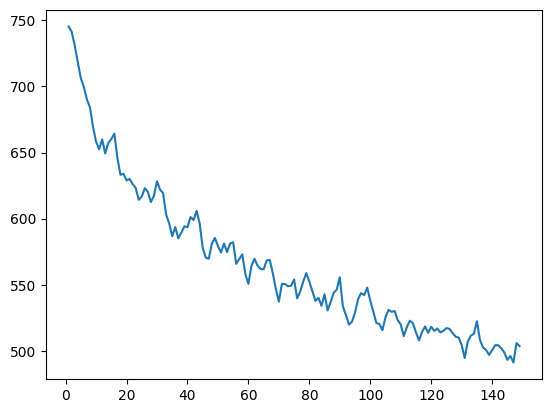

In [43]:
import matplotlib.pyplot as plt

epoch = range(1,len(loss_list))
plt.plot(epoch, loss_list[1:])
plt.show()

In [64]:
# epoch = range(0,40)
# plt.plot(epoch, mse_loss_list)
# plt.show()

In [44]:
import numpy as np

def CalcHammingDist(B1, B2):
    q = B2.shape[1]
    distH = 0.5 * (q - np.dot(B1, B2.transpose()))
    return distH

def CalcMap(qB, rB, queryL, retrievalL):
    num_query = queryL.shape[0]
    map = 0
    for iter in range(num_query):
        gnd = (np.dot(queryL[iter, :], retrievalL.transpose()) > 0).astype(np.int64)
        tsum = np.sum(gnd)
        if tsum == 0:
            continue
        hamm = CalcHammingDist(qB[iter, :], rB)
        ind = np.argsort(hamm)
        gnd = gnd[ind]
        count = np.linspace(1, tsum, tsum)
        tindex = np.asarray(np.where(gnd == 1)) + 1.0
        map_ = np.mean(count / (tindex))
        map = map + map_
    map = map / num_query
    return map

def CalcTopMap(qB, rB, queryL, retrievalL, topk):
    num_query = queryL.shape[0]
    topkmap = 0
    for iter in range(num_query):
        gnd = (np.dot(queryL[iter, :], retrievalL.transpose()) > 0).astype(np.int64)
        hamm = CalcHammingDist(qB[iter, :], rB)
        ind = np.argsort(hamm)
        gnd = gnd[ind]
        tgnd = gnd[0:topk]
        tsum = np.sum(tgnd)
        if tsum == 0:
            continue
        count = np.linspace(1, tsum, tsum)
        tindex = np.asarray(np.where(tgnd == 1)) + 1.0
        topkmap_ = np.mean(count / (tindex))
        topkmap = topkmap + topkmap_
    topkmap = topkmap / num_query
    return topkmap


In [45]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_values, std=std_values)
        ])

CIFAR10_test = torchvision.datasets.CIFAR10(root =  'Datasets', download=True, transform=transform, train = False)

testloader = DataLoader(CIFAR10_test, batch_size= 256,shuffle= True)

Files already downloaded and verified


In [46]:
list = []
labels_list = []
for images, labels in testloader:

    images = images.to(device)
    labels = labels.to(device)
    
    resnet_model.eval()
    U  = resnet_model(images)
    B = torch.sgn(U)
    B  = B.detach().cpu().numpy().astype(np.int64)
    list.append(B)

    labels = F.one_hot(labels).detach().cpu().numpy()
    labels_list.append(labels)

qB = np.concatenate(list, axis = 0)
test_labels = np.concatenate(labels_list, axis = 0)

In [47]:
list = []
labels_list = []
for images, labels in dataloader:

    images = images.to(device)
    labels = labels.to(device)
    
    resnet_model.eval()
    U  = resnet_model(images)
    B = torch.sgn(U)
    B  = B.detach().cpu().numpy().astype(np.int64)
    list.append(B)

    labels = F.one_hot(labels).detach().cpu().numpy()
    labels_list.append(labels)

rB = np.concatenate(list, axis = 0)
train_labels = np.concatenate(labels_list)

In [34]:
qB.shape

(10000, 16)

In [52]:
CalcMap(qB, rB, test_labels, train_labels)

0.5241879057159411

In [49]:
topk = 15
CalcTopMap(qB, rB, test_labels, train_labels, topk)

0.472501222588073